In [1]:
import os

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
from pathlib import Path
root_path = Path.cwd().parent.absolute()
import sys
sys.path.append(str(root_path))
import os

In [2]:

from flax import nnx
import jax
import jax.numpy as jnp

In [3]:
from geometry.G_matrix import G_matrix
from functionals.functions import create_potentials
from functionals.linear_funcitonal_class import LinearPotential
from functionals.internal_functional_class import InternalPotential
from functionals.interaction_functional_class import InteractionPotential
from functionals.functional import Potential
from flows.anderson_acceleration import anderson_method
from parametric_model.parametric_model import ParametricModel
from flows.gradient_flow import run_gradient_flow
from flows.visualization import visualize_gradient_flow_results
from functionals.functions import aggregation_potential_fn,zero_potential_fn,styblinski_tang_potential_fn


In [4]:
# Define the parametric model
parametric_model = ParametricModel(
    parametric_map="resnet", # "node" "resnet"
    architecture=[2, 2, 64], # [input_dim, num_layers, hidden_width]
    activation_fn="tanh", # "tanh", "relu", "SinTu", "identity", "sigmoid", "gelu", "swish"
    time_dependent=True,    # True or False
    solver="euler", # "euler" or "heun"
    dt0=0.1,
    rhs_model="mlp", # "mlp" or "resnet"
    ref_density="gaussian",
    scale_factor=2.5e-2
)


# Anderson acceleration

In [62]:
# Anderson parameters
h = 1e-2 # Time step size
m = 8 # Number of previous iterates to consider
beta = 1.25 # Damping parameter
max_iterations = 450
tolerance = 1e-5
n_samples = 10_000  # Monte Carlo sample size
solver_max_iter = 10


key = jax.random.PRNGKey(1234)
rngs = nnx.Rngs(key)


# Generate reference samples from λ = N(0, I)
key, subkey = jax.random.split(key)
z_samples = jax.random.normal(subkey, (n_samples, 2))

G_mat_flow = G_matrix(parametric_model)

solver= 'cg' # minres or cg


In [63]:
linear_potential = LinearPotential(potential_fn= zero_potential_fn, coeff = 2.0)
internal_potential = InternalPotential(functional='entropy', coeff = 10, method= 'exact',prob_dim=2)
interaction_potential = InteractionPotential(interaction_fn = aggregation_potential_fn, coeff = 1, a = 4, b = 2)

potential = Potential(linear = linear_potential,
                      internal = None,
                      interaction = interaction_potential)

Starting Anderson-accelerated gradient flow
  n_iterations: 450
  step_size: 0.01
  memory_size: 8
  mixing_parameter: 1.25
------------------------------------------------------------
Iter    0 | Energy: 2.029052e+00 | Residual: 3.629176e-01 | 


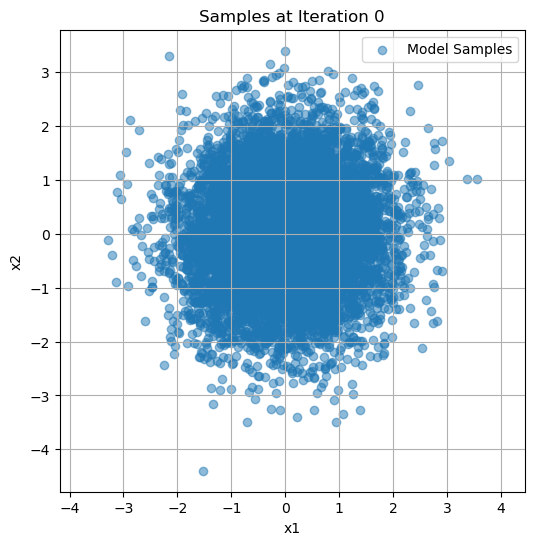

Iter   10 | Energy: -5.398342e-02 | Residual: 1.596400e-02 | 


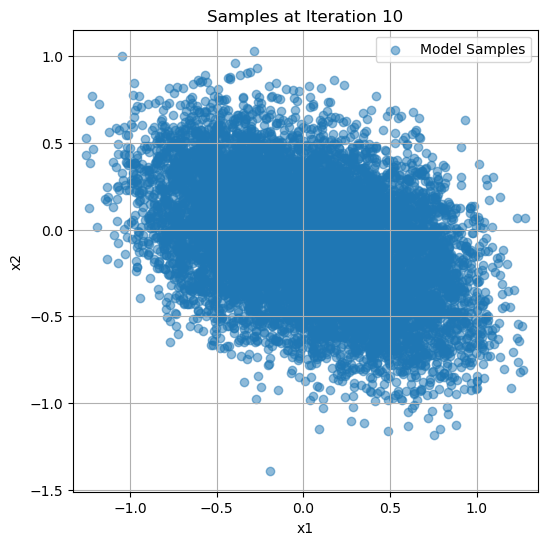

Iter   20 | Energy: -6.336476e-02 | Residual: 2.504562e-03 | 


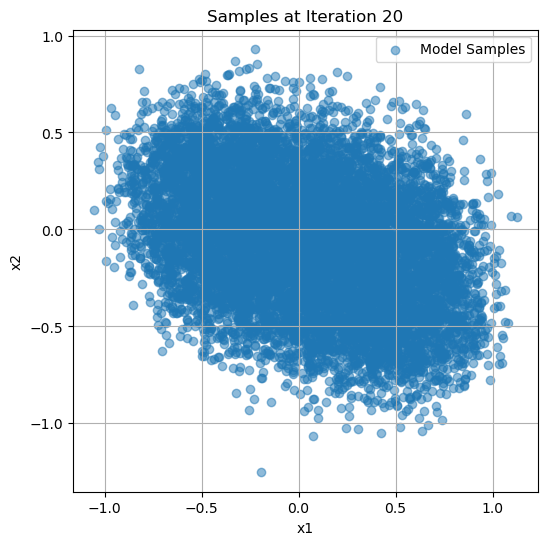

Iter   30 | Energy: -6.731002e-02 | Residual: 4.531370e-03 | 


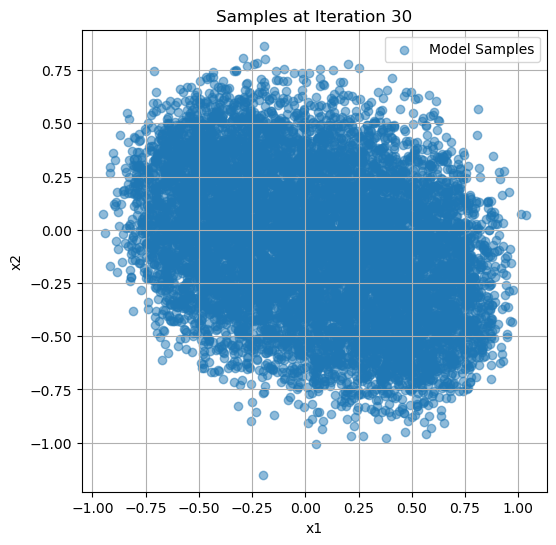

Iter   40 | Energy: -6.972858e-02 | Residual: 3.076504e-04 | 


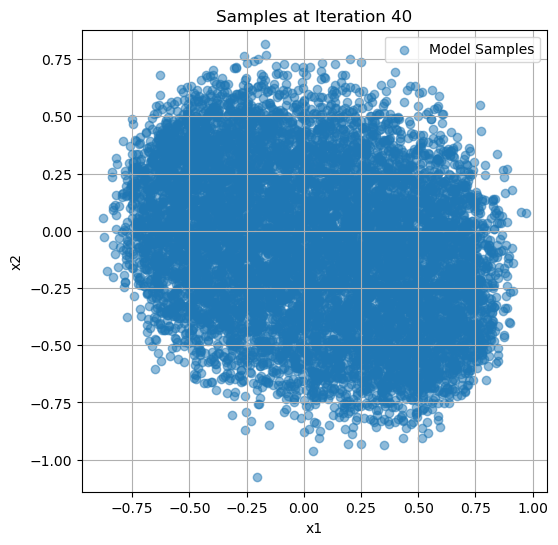

Iter   50 | Energy: -7.138079e-02 | Residual: 4.131620e-03 | 


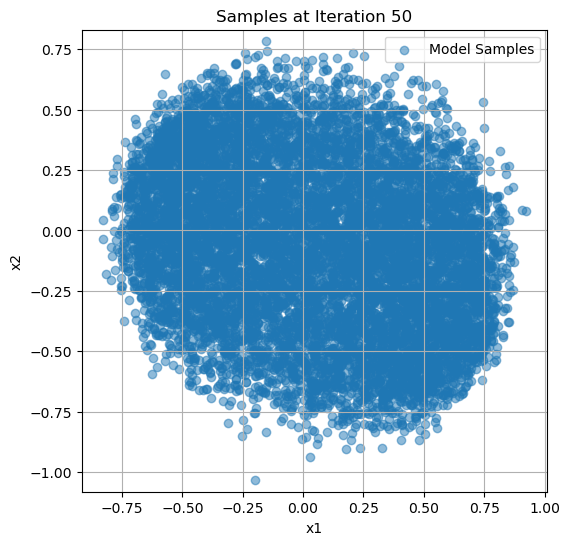

Iter   60 | Energy: -7.267199e-02 | Residual: 1.627967e-03 | 


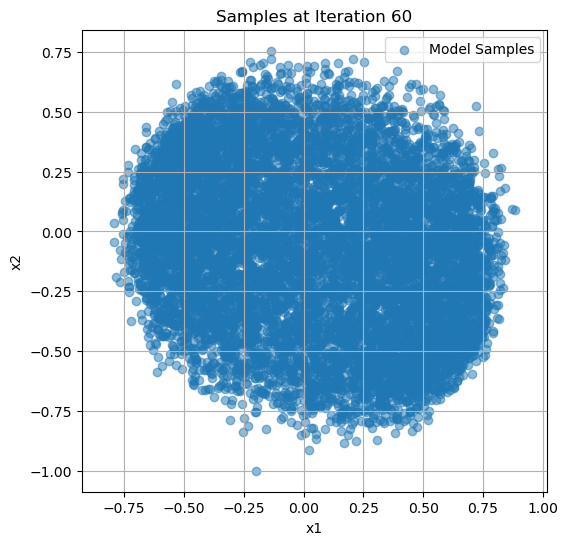

Iter   70 | Energy: -7.375792e-02 | Residual: 1.003715e-03 | 


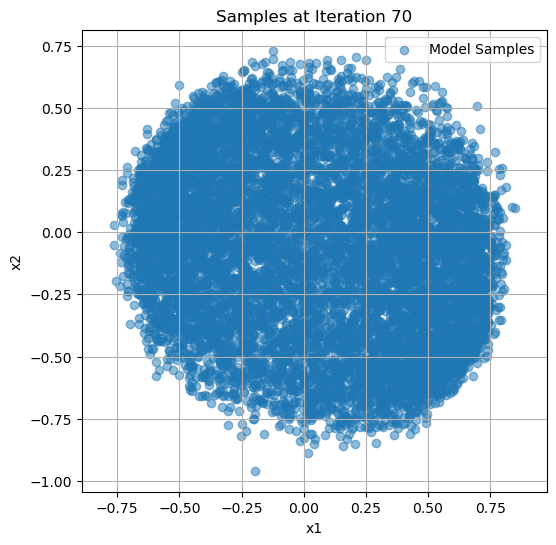

KeyboardInterrupt: 

In [64]:
current_params, history_anderson = anderson_method(
    parametric_model=parametric_model,
    batch_size=n_samples,
    test_data_set=z_samples,
    G_mat=G_mat_flow,
    potential=potential,
    initial_params= None,
    n_iterations=max_iterations,
    step_size=h,
    memory_size=m,
    mixing_parameter=beta,
    anderson_tol=1e-5,
    solver = solver,
    solver_tol=1e-4,
    solver_maxiter=solver_max_iter
)

# Gradient flow

In [39]:
# Gradient flow parameters
h = 1e-3 # Time step size
max_iterations = 450
tolerance = 1e-5
n_samples = 3_000  # Monte Carlo sample size


key = jax.random.PRNGKey(1234)
rngs = nnx.Rngs(key)


# Generate reference samples from λ = N(0, I)
key, subkey = jax.random.split(key)
z_samples = jax.random.normal(subkey, (n_samples, 2))

G_mat_flow = G_matrix(parametric_model)

solver= 'cg'


Gradient Flow Progress:   6%|▌         | 25/449 [00:41<10:37,  1.50s/it, Energy=0.848555, Linear=0.000000, Internal=0.000000, Interaction=0.848555]

Iter  25: Energy = 0.848555, Grad norm: 5.45e+00


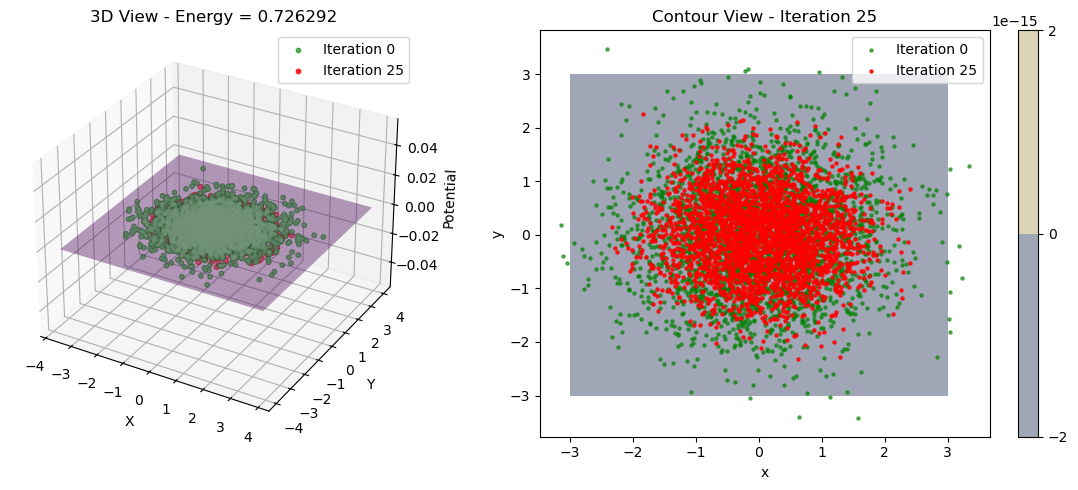

Gradient Flow Progress:  11%|█         | 50/449 [01:20<10:01,  1.51s/it, Energy=0.395221, Linear=0.000000, Internal=0.000000, Interaction=0.395221]

Iter  50: Energy = 0.395221, Grad norm: 3.54e+00


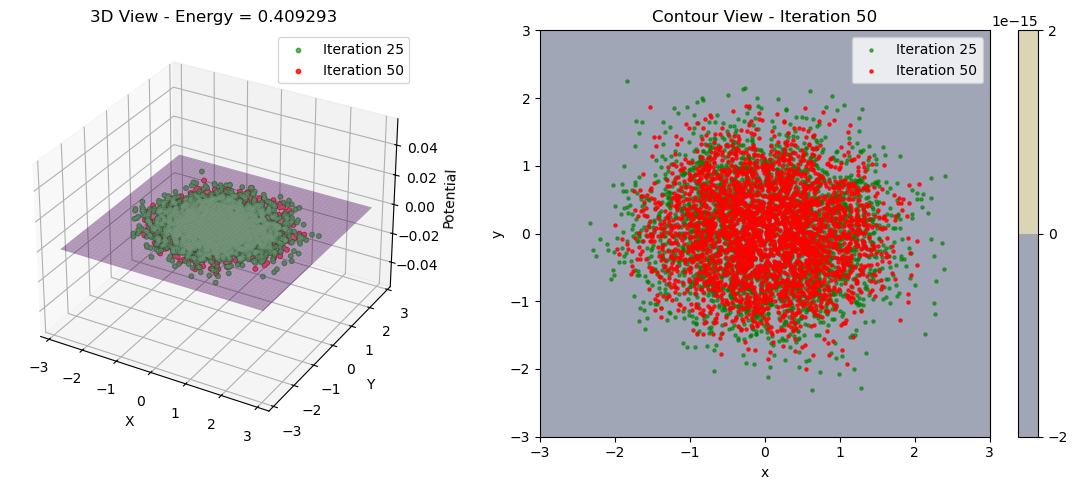

Gradient Flow Progress:  17%|█▋        | 75/449 [01:58<09:19,  1.50s/it, Energy=0.230673, Linear=0.000000, Internal=0.000000, Interaction=0.230673]

Iter  75: Energy = 0.230673, Grad norm: 2.71e+00


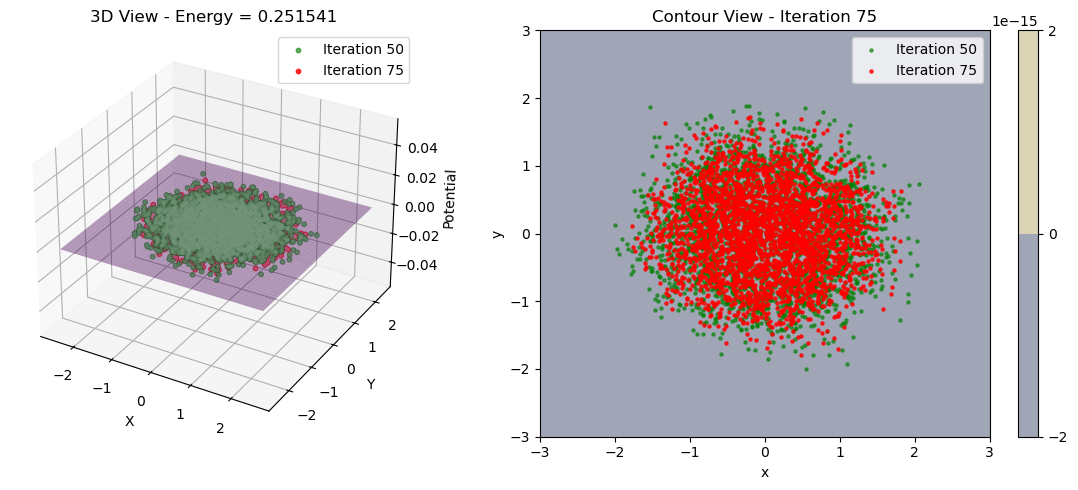

Gradient Flow Progress:  22%|██▏       | 100/449 [02:37<08:46,  1.51s/it, Energy=0.184624, Linear=0.000000, Internal=0.000000, Interaction=0.184624]

Iter 100: Energy = 0.184624, Grad norm: 2.45e+00


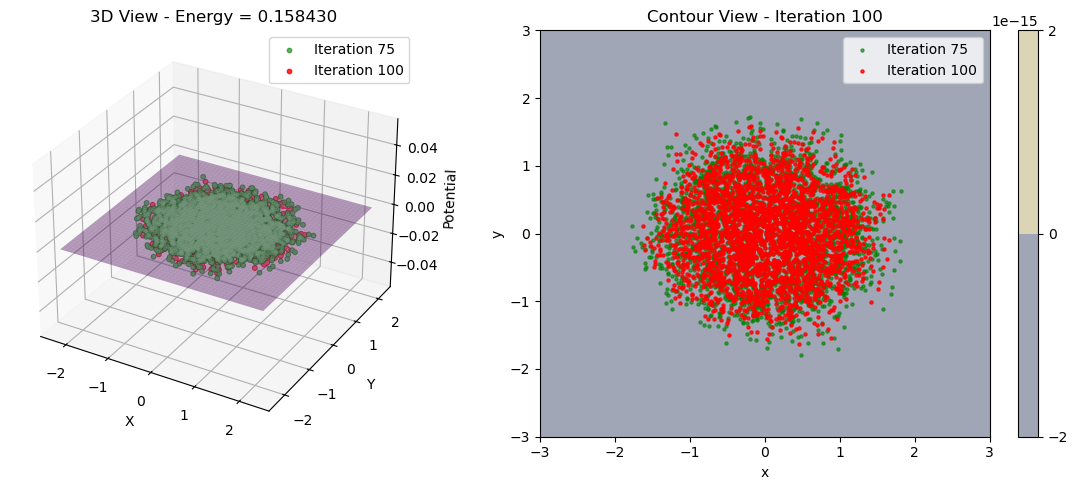

Gradient Flow Progress:  28%|██▊       | 125/449 [03:16<08:09,  1.51s/it, Energy=0.105578, Linear=0.000000, Internal=0.000000, Interaction=0.105578]

Iter 125: Energy = 0.105578, Grad norm: 1.94e+00


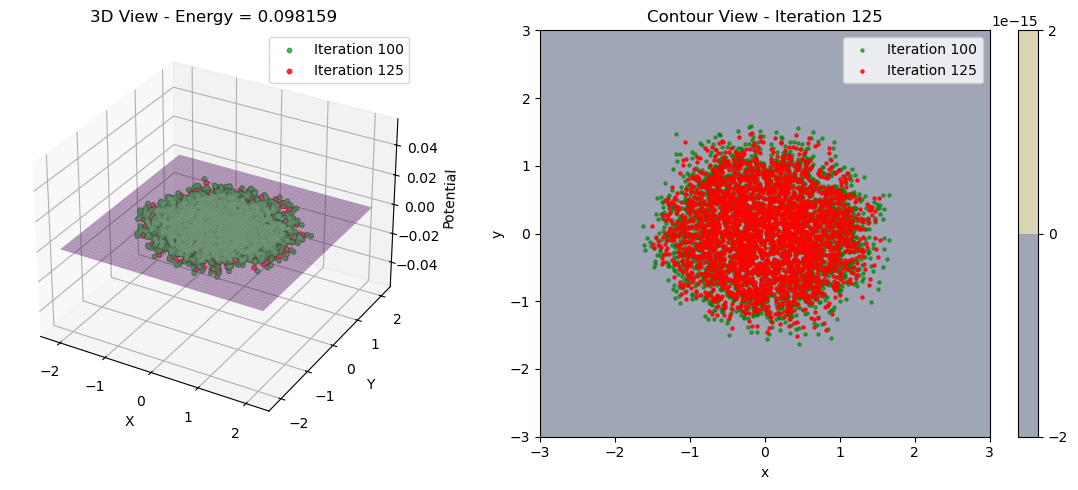

Gradient Flow Progress:  33%|███▎      | 150/449 [03:55<07:31,  1.51s/it, Energy=0.059928, Linear=0.000000, Internal=0.000000, Interaction=0.059928]

Iter 150: Energy = 0.059928, Grad norm: 1.59e+00


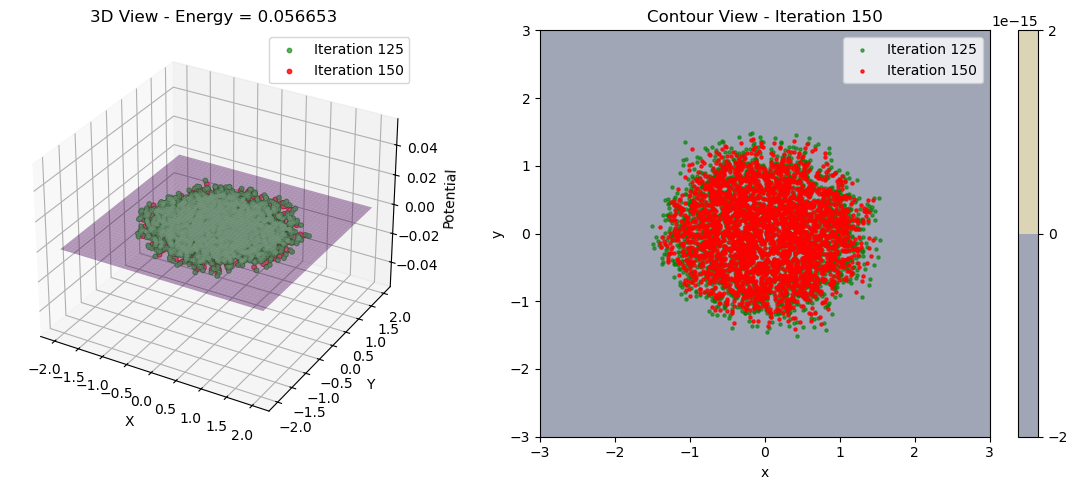

Gradient Flow Progress:  39%|███▉      | 175/449 [04:36<06:53,  1.51s/it, Energy=0.032172, Linear=0.000000, Internal=0.000000, Interaction=0.032172]

Iter 175: Energy = 0.032172, Grad norm: 1.40e+00


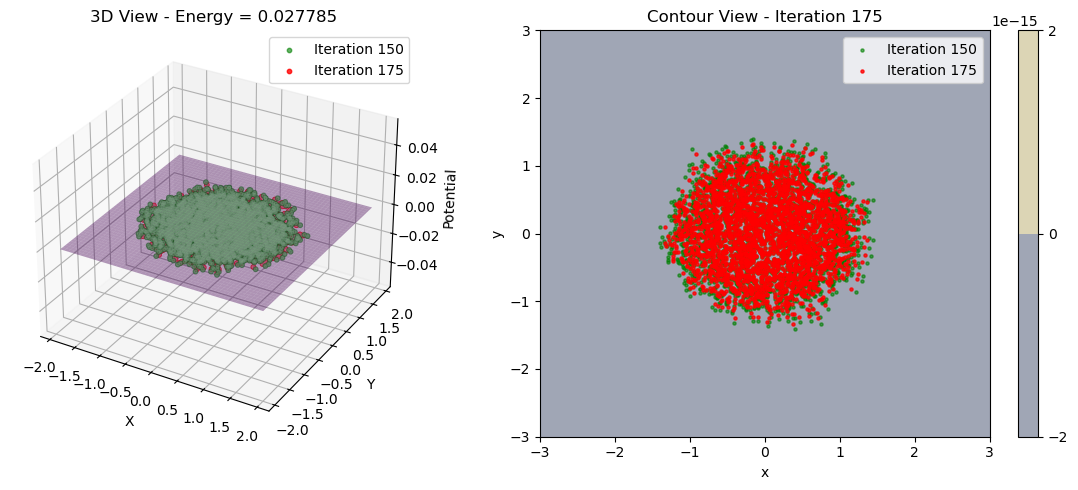

Gradient Flow Progress:  45%|████▍     | 200/449 [05:15<06:16,  1.51s/it, Energy=0.000998, Linear=0.000000, Internal=0.000000, Interaction=0.000998]

Iter 200: Energy = 0.000998, Grad norm: 1.13e+00


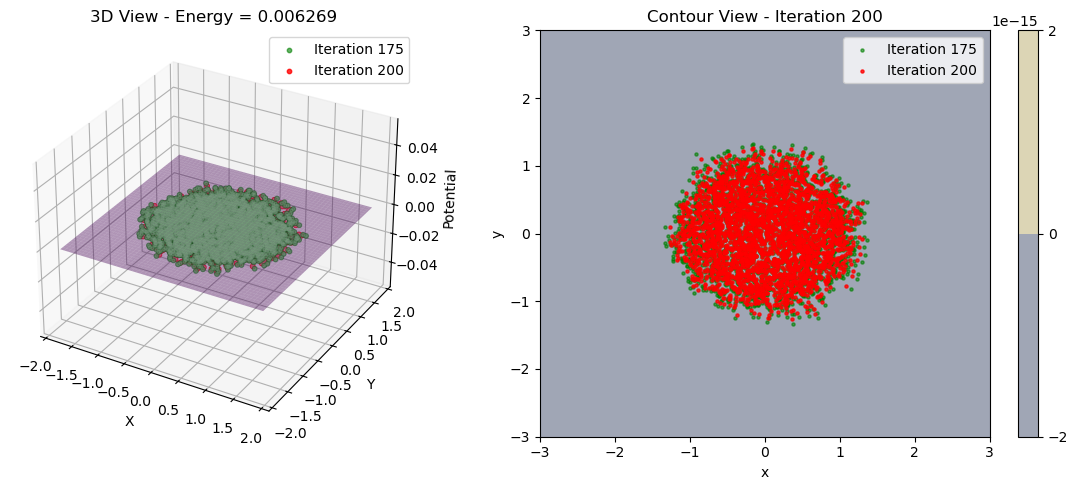

Gradient Flow Progress:  50%|█████     | 225/449 [05:54<05:39,  1.52s/it, Energy=-0.005116, Linear=0.000000, Internal=0.000000, Interaction=-0.005116]

Iter 225: Energy = -0.005116, Grad norm: 1.02e+00


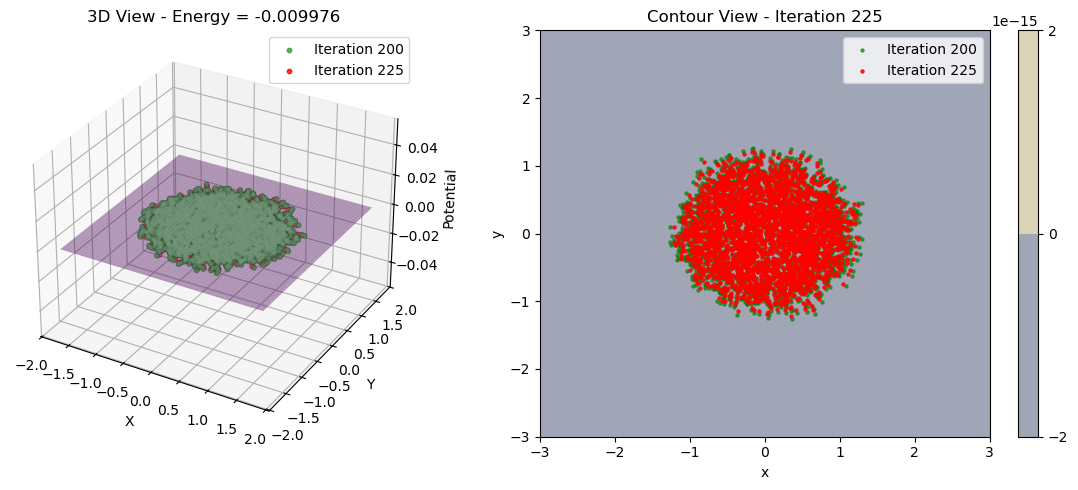

Gradient Flow Progress:  56%|█████▌    | 250/449 [06:33<04:58,  1.50s/it, Energy=-0.004984, Linear=0.000000, Internal=0.000000, Interaction=-0.004984]

Iter 250: Energy = -0.004984, Grad norm: 1.09e+00


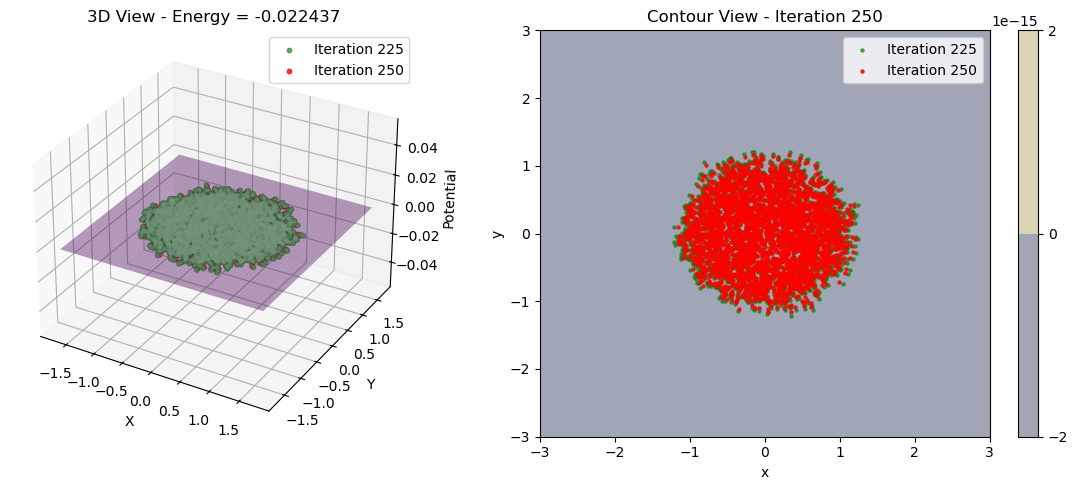

Gradient Flow Progress:  61%|██████    | 275/449 [07:12<04:21,  1.50s/it, Energy=-0.023029, Linear=0.000000, Internal=0.000000, Interaction=-0.023029]

Iter 275: Energy = -0.023029, Grad norm: 8.85e-01


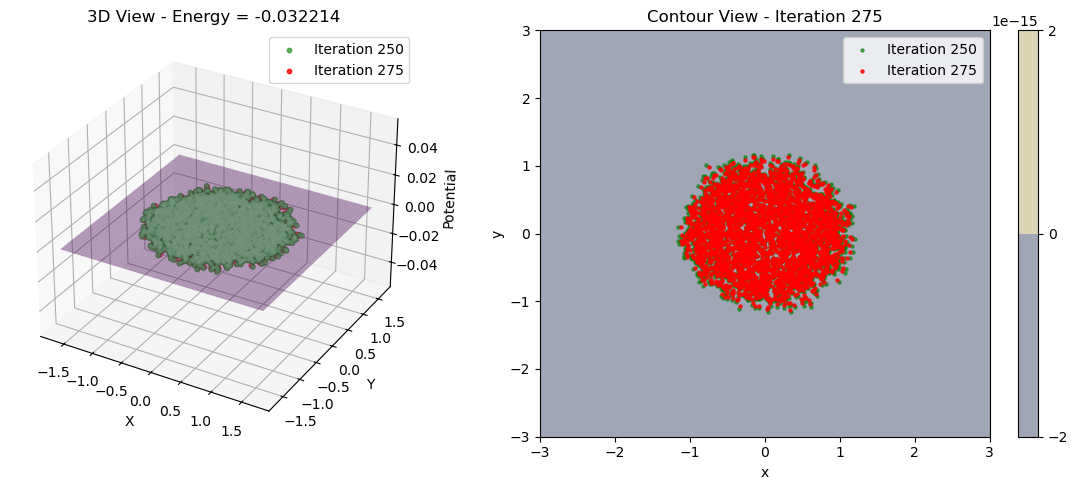

Gradient Flow Progress:  67%|██████▋   | 300/449 [07:50<03:44,  1.51s/it, Energy=-0.039639, Linear=0.000000, Internal=0.000000, Interaction=-0.039639]

Iter 300: Energy = -0.039639, Grad norm: 7.31e-01


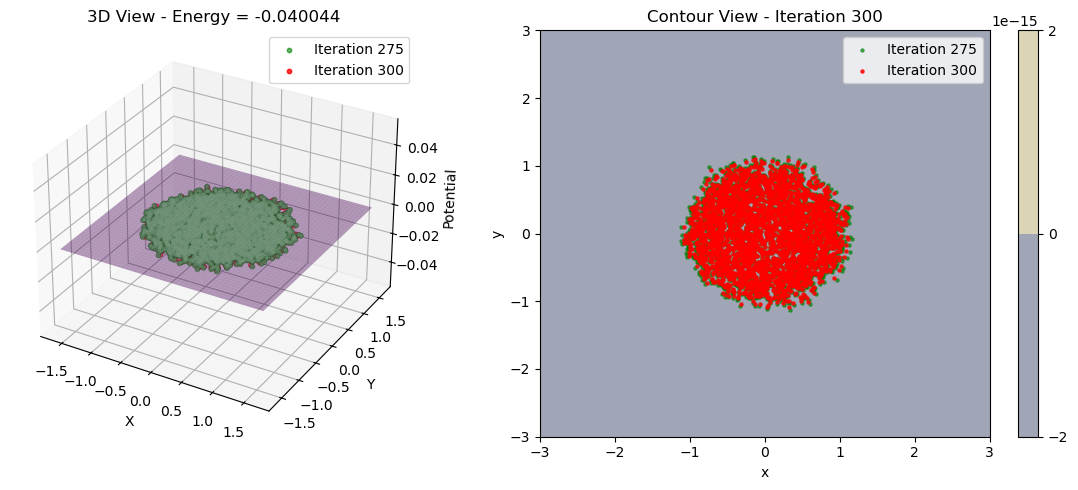

Gradient Flow Progress:  72%|███████▏  | 325/449 [08:29<03:06,  1.50s/it, Energy=-0.049438, Linear=0.000000, Internal=0.000000, Interaction=-0.049438]

Iter 325: Energy = -0.049438, Grad norm: 5.80e-01


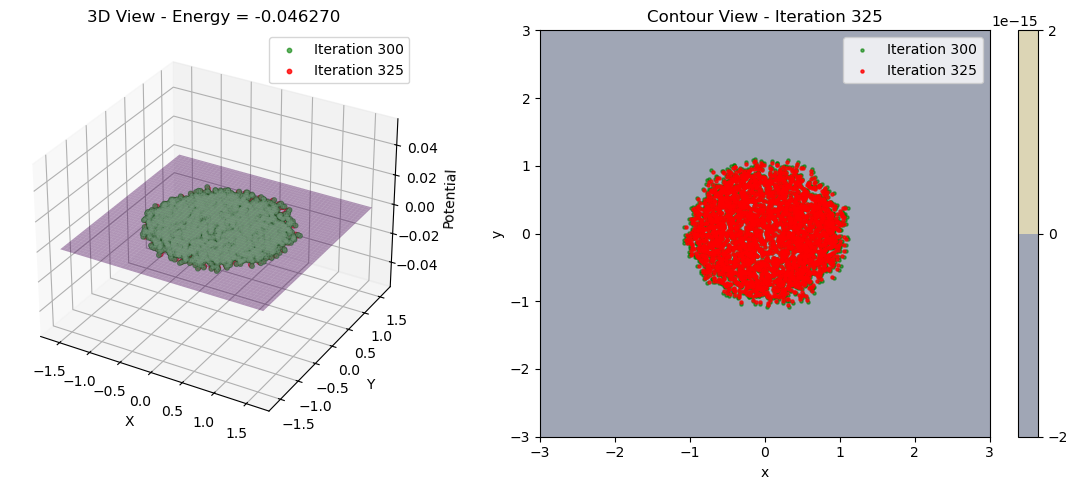

Gradient Flow Progress:  78%|███████▊  | 350/449 [09:08<02:29,  1.51s/it, Energy=-0.050469, Linear=0.000000, Internal=0.000000, Interaction=-0.050469]

Iter 350: Energy = -0.050469, Grad norm: 5.54e-01


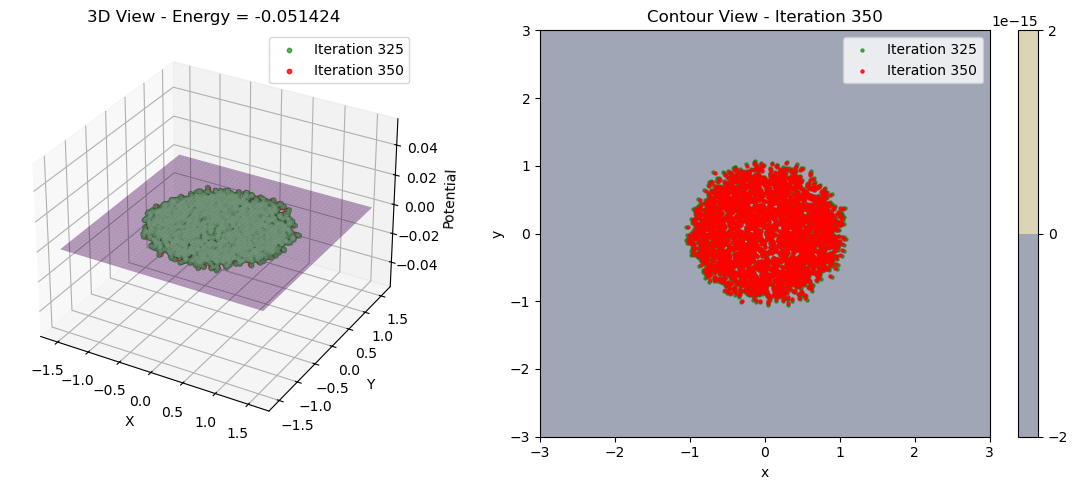

Gradient Flow Progress:  84%|████████▎ | 375/449 [09:50<01:51,  1.51s/it, Energy=-0.058368, Linear=0.000000, Internal=0.000000, Interaction=-0.058368]

Iter 375: Energy = -0.058368, Grad norm: 4.63e-01


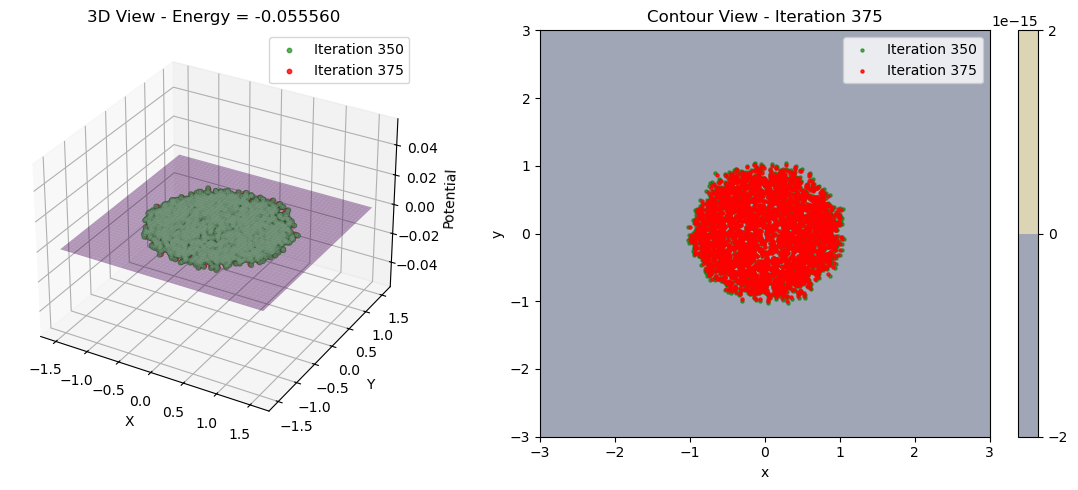

Gradient Flow Progress:  89%|████████▉ | 400/449 [10:30<01:20,  1.65s/it, Energy=-0.062762, Linear=0.000000, Internal=0.000000, Interaction=-0.062762]

Iter 400: Energy = -0.062762, Grad norm: 3.71e-01


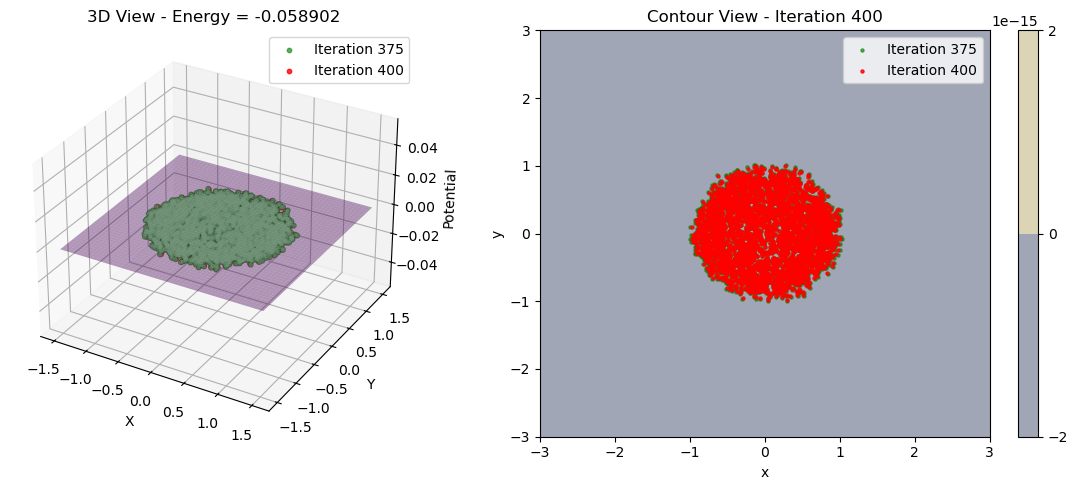

Gradient Flow Progress:  95%|█████████▍| 425/449 [11:13<00:40,  1.69s/it, Energy=-0.062658, Linear=0.000000, Internal=0.000000, Interaction=-0.062658]

Iter 425: Energy = -0.062658, Grad norm: 3.55e-01


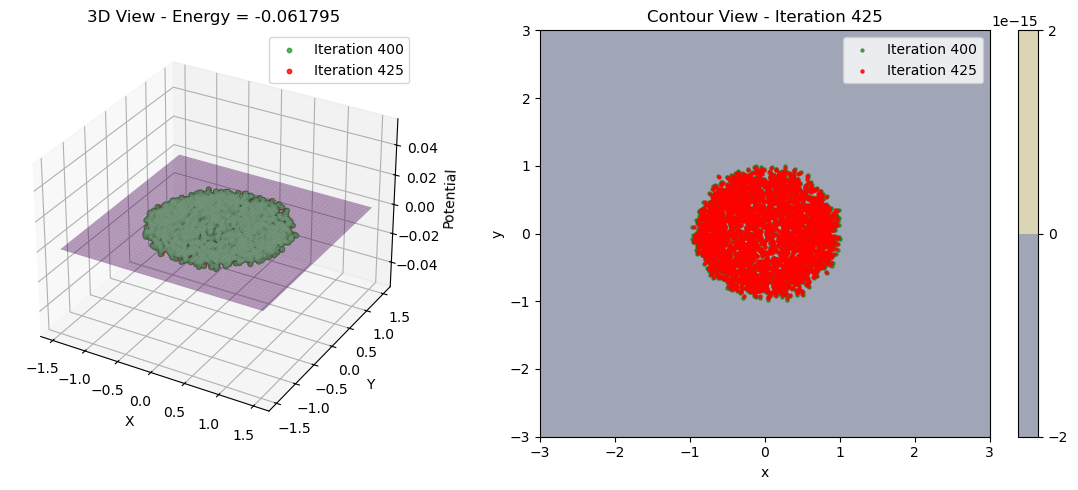

Gradient Flow Progress: 100%|█████████▉| 448/449 [11:52<00:01,  1.63s/it, Energy=-0.056195, Linear=0.000000, Internal=0.000000, Interaction=-0.056195]

Iter 448: Energy = -0.056195, Grad norm: 4.57e-01


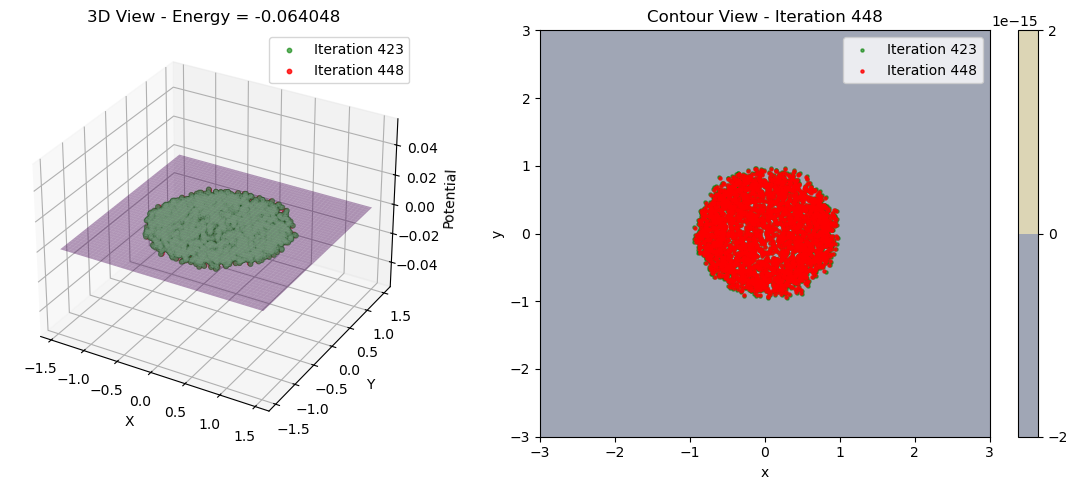

Gradient Flow Progress: 100%|██████████| 449/449 [11:53<00:00,  1.59s/it, Energy=-0.056195, Linear=0.000000, Internal=0.000000, Interaction=-0.056195]


=== Integration Complete ===
Total iterations:    448
Initial energy:      3.196719
Final energy:        -0.056195
Total decrease:      3.252914
Reduction ratio:     -0.0176
Final param norm:    4.112815


In [40]:

results = run_gradient_flow(
    parametric_model, z_samples, G_mat_flow,
    potential
    ,solver=solver,
    h=h, max_iterations=max_iterations, tolerance=tolerance,
    progress_every=25,regularization=1e-6
)

In [48]:
history_anderson.keys(),results.keys(),results['convergence_info'].keys()

(dict_keys(['params', 'residual_norms', 'energies', 'final_iteration', 'param_history', 'residual_history', 'param_diffs', 'residual_diffs']),
 dict_keys(['final_parametric_model', 'energy_history', 'param_norms', 'sample_history', 'potential', 'convergence_info']),
 dict_keys(['converged', 'final_energy', 'total_decrease', 'iterations']))

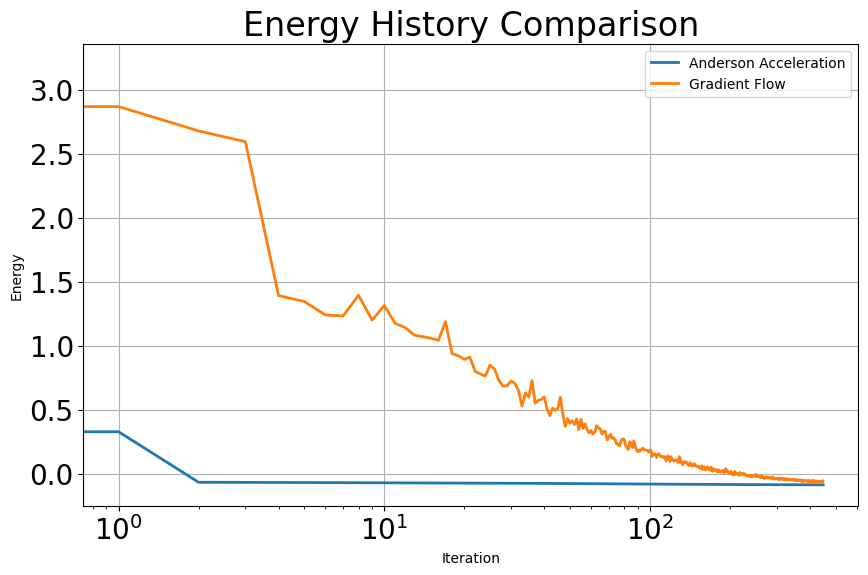

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history_anderson['energies'], label='Anderson Acceleration', linewidth=2)
plt.plot(results['energy_history'], label='Gradient Flow', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.xscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Energy History Comparison', fontsize=24)
plt.legend()
plt.grid(True)
plt.show()

In [51]:
len(history_anderson['energies']),len(results['energy_history'])

(450, 449)